In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from IPython.display import display
import pdb
from multiprocessing import Pool
import os
import pandas as pd

## Load the list of images for possible colorwheels

In [2]:
imageList = os.listdir('../images/')
print "Available images: " + str(len(imageList))

Available images: 79


## Define the graphics and plotting functions

In [3]:
# GRAPHICS FUNCTIONS

def getRGB(z,minx,maxx,miny,maxy, imArray):
    dimx,dimy,_ = imArray.shape
    x = z.real
    y = z.imag
    xCoor = int(np.round(((x - minx)/float(maxx - minx)) * (dimx-1)))
    # if maxy = miny and you get an error, this is a degeneracy. use complex coefficients in nmDict !!!!
    yCoor = int(np.round(((y - miny)/float(maxy - miny)) * (dimy-1)))
        
    value = imArray[xCoor, yCoor, :]
    return value

def colorwheelApply(gridApply, imArray):
    allx = [z.real for z in gridApply.values()]
    ally = [z.imag for z in gridApply.values()]
    minx = min(allx)
    maxx = max(allx)
    miny = min(ally)
    maxy = max(ally)
    
    fundamentalDict = {}
    for key,value in gridApply.items():
        fundamentalDict[key] = getRGB(value,minx,maxx,miny,maxy, imArray)
    return fundamentalDict


def checkSymmetrySimple(gridApply):
    
    fundamentalDict = {}
    for key,value in gridApply.items():
         fundamentalDict[key] = np.array(((value.real * 1024) % 256 ,0, (value.imag * 1024) % 256), dtype='uint8')
        
    return fundamentalDict


def checkSymmetrySimpleReal(gridApply):
    
    fundamentalDict = {}
    allValues = [i.real for i in gridApply.values()]
    minx = min(allValues)
    maxx = max(allValues)
    span = maxx - minx
    for key,value in gridApply.items():
         fundamentalDict[key] = np.array((int(((value.real - minx)/span) * 255),0,0), dtype = 'uint8')
        
    return fundamentalDict

def checkSymmetrySimpleImag(gridApply):
    
    fundamentalDict = {}
    allValues = [i.imag for i in gridApply.values()]
    miny = min(allValues)
    maxy = max(allValues)
    span = maxy - miny
    for key,value in gridApply.items():
         fundamentalDict[key] = np.array((0,0,int(((value.imag - miny)/span) * 255)), dtype = 'uint8')
        
    return fundamentalDict

def fundamentalColorGet(thisTuple):
    
    x,y = thisTuple[0]
    fundamentalDict = thisTuple[1]
    numStep = thisTuple[2]
    i,j = thisTuple[3]
    
    # convert x,y to lattice basis
    
    xPrime, yPrime = np.dot(d,[x,y])
    xIndex = int((xPrime % 1) * (numStep-1))
    yIndex = int((yPrime % 1) * (numStep-1))
    
    value = fundamentalDict[(xIndex,yIndex)]
    
    return ((i,j), value)
    

def tileFundamental(fundamentalDict, numStep, xmin, xmax, ymin, ymax, resx, resy):

    if resy == None:
        resy = int((resx * (ymax-ymin))/float(xmax - xmin))
        
    xv = np.linspace(xmin, xmax, resx)
    yv = np.linspace(ymin, ymax, resy)
    
    grid = [((x,y), fundamentalDict, numStep, (i,j)) for i,x in enumerate(xv) for j,y in enumerate(yv)]
    coordinateDict = dict([fundamentalColorGet(i) for i in grid])
    
    imOut = np.zeros((resy, resx, 3), dtype='uint8')
    for key,value in coordinateDict.items():
        i,j = key
        imOut[resy - j - 1, i, :] = value
        
    return imOut


def latticeEval(thisTuple):
    i,x,j,y,myF,nmDict,lattice_vector_1,lattice_vector_2 = thisTuple
    
    z = (x * lattice_vector_1) + (y * lattice_vector_2)
    
    return ((i,j), myF(nmDict)((z.real, z.imag)))


def fundamentalCellDisplay(fundamentalDict, resx, resy):

    extremePoints = [0., lattice_vector_1, lattice_vector_2, lattice_vector_1 + lattice_vector_2]
    minx = min([i.real for i in extremePoints])
    maxx = max([i.real for i in extremePoints])
    miny = min([i.imag for i in extremePoints])
    maxy = max([i.imag for i in extremePoints])
    
    gap = max([maxy - miny, maxx - minx])
    maxx = minx + gap
    maxy = miny + gap
    
    imOut = np.zeros((resy, resx, 3), dtype='uint8')
    for key,value in fundamentalDict.items():
        z = ((lattice_vector_1 * key[0]) + (lattice_vector_2 * key[1])) / numStep
        x = z.real
        y = z.imag
        
        i = int(((x - minx)/(maxx-minx)) * (resx-1))
        j = int(((y - miny)/(maxy-miny)) * (resy-1))
        imOut[resy - j - 1,i,:] = value
     
    display(Image.fromarray(imOut))



## Here we define the essential symmetry functions, following the appendix in the book.

In [4]:
# SYMMETRY FUNCTIONS

# GENERAL LATTICE
def E_general(nmPair,x,y):
    n,m = nmPair
    a = lattice_vector_2.real
    b = lattice_vector_2.imag
    X = x - ((a * y)/b)
    Y = y/b
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def f_general(nmDict):
    g = lambda xyPair : np.sum([value * E_general(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g


# RHOMBIC LATTICE
def E_rhombic(nmPair,x,y):
    n,m = nmPair
    X = x + (y/(2.*b))
    Y = x - (y/(2.*b))
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def f_rhombic(nmDict):
    g = lambda xyPair : np.sum([value * E_rhombic(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g


# RECTANGULAR LATTICE
def E_rectangular(nmPair,x,y):
    n,m = nmPair
    X = x 
    Y = y/L
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def f_rectagular(nmDict):
    g = lambda xyPair : np.sum([value * E_rectangular(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g


# SQUARE LATTICE
def E_square(nmPair,x,y):
    n,m = nmPair
    X = x 
    Y = y
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def S(nmPair0,x,y):
    n,m = nmPair0
    nmPair1 = (m,-n)
    nmPair2 = (-n,-m)
    nmPair3 = (-m,n)
    value = (E_square(nmPair0,x,y) + E_square(nmPair1,x,y) + E_square(nmPair2,x,y) + E_square(nmPair3,x,y))/4.
    return value

def f_square(nmDict):
    g = lambda xyPair : np.sum([value * S(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g

# HEXAGONAL LATTICE
def E_hex(nmPair,x,y):
    n,m = nmPair
    X = x + (y/np.sqrt(3))
    Y = (2 * y)/np.sqrt(3)
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def W(nmPair0,x,y):
    n,m = nmPair0
    nmPair1 = (m, -n - m)
    nmPair2 = (-n - m, n)
    value = (E_hex(nmPair0,x,y) + E_hex(nmPair1,x,y) + E_hex(nmPair2,x,y))/3.
    return value

def f_hex(nmDict):
    g = lambda xyPair : np.sum([value * W(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g


## Set the lattice type and the symmetry group.

In [5]:
def colorWheelGet(imageList, index='random'):
    
    if index=='random':
        imageName = np.random.choice(imageList)
    else:
        imageName = imageList[index]
        
    im = Image.open("../images/" + imageName)
    colorWheel = np.array(im)
    print "We use %s as the colorwheel!" % imageName
    print "Image shape: " + str(im.size)
    return colorWheel, imageName

def symmetryExampleGet(latticeName):
    if latticeName == 'random':
        flag = np.random.choice(['general','rhombic','square','rectangular','hexagonal'])
    else:
        flag = latticeName

    print "We use the %s lattice." % flag


    if flag == 'general':
        myF = f_general

        # lattice_vector_2 is arbitrary
        lattice_vector_1 = 1.
        lattice_vector_2 = 1j

        #nmDict_p1 = {(1,0):1, (0,-1):1, (1,5):.5, (-5,-1):.5, (-2,4):.1*1j, (-4,2):.1*1j}
        nmDict_p1 = {(1,0):1}
        nmDict_p2 = {(1,0):1, (-1,0):1, (1,5):.5, (-1,-5):.5, (-2,4):.1*1j, (2,-4):.1*1j}

        nmDict = nmDict_p1

    elif flag == 'rhombic':
        myF = f_rhombic

        # lattice vectors are defined by b
        b = .5
        lattice_vector_1 = .5 + (b*1j)
        lattice_vector_2 = .5 - (b*1j)

        nmDict_cm = {(2,3):1j, (3,2):1j}
        nmDict_cmm = {(2,3):1 + 1j, (3,2):1 + 1j, (-2,-3):1 + 1j, (-3,-2):1 + 1j}

        nmDict = nmDict_cm

    elif flag == 'rectangular':
        myF = f_rectagular

        # lattice vectors determined by L
        L = 2.
        lattice_vector_1 = 1.
        lattice_vector_2 = L * 1j

        nmDict_pm = {(1,2):1j, (1,-2):1j}
        nmDict_pg = {(3,5):1 + 1j, (3,-5):-1-1j}
        nmDict_pmm = {(1,2):1 + 1j, (-1,-2):1 + 1j, (-1,2):1 + 1j, (1,-2):1 + 1j}
        nmDict_pmg = {(1,2):1 + 1j, (-1,-2):1 + 1j, (-1,2):-1 - 1j, (1,-2):-1 - 1j}
        nmDict_pgg = {(1,1):1 + 1j, (-1,-1):1 + 1j, (-1,1):1 + 1j, (1,-1):1 + 1j}


        nmDict = nmDict_pgg

    elif flag == 'square':
        myF = f_square

        # lattice vectors are fixed
        lattice_vector_1 = 1.
        lattice_vector_2 = 1j

        nmDict_p4 = {(1,0):1, (0,-1):1, (1,5):.5, (-5,-1):.5, (-2,4):.1*1j, (-4,2):.1*1j} 
        nmDict_p4m = {(1,0):1, (0,1):1, (-1,-5):.5, (-5,-1):.5, (-2,4):.1*1j, (4,-2):.1*1j}
        nmDict_p4g = {(1,2):1j, (2,1):-1j, (-1,3):5, (3,-1):5}

        nmDict = nmDict_p4g

    elif flag == 'hexagonal':
        myF = f_hex

        # lattice vectors are fixed
        lattice_vector_1 = 1.
        lattice_vector_2 = (-1 + (1j * np.sqrt(3)))/2.

        #nmDict_p3 = {(1,0):1, (0,-1):1, (1,5):.5, (-5,-1):.5, (-2,4):.1*1j, (-4,2):.1*1j} 
        nmDict_p3 = {(1,0):1}
        nmDict_p31m = {(2,4):2 + 1j, (4,2):2 + 1j} 
        nmDict_p3m1 = {(2,4):2 + 1j, (-4,-2):2 + 1j} 
        nmDict_p6 = {(1,0):2 + 1j, (-1,0):2 + 1j} 
        nmDict_p6m = {(1,3):2 + 1j, (-1,-3):2 + 1j, (3,1):2 + 1j, (-3,-1):2 + 1j} 

        nmDict = nmDict_p3

    else:
        raise Exception('bad type...')
    
    return (lattice_vector_1, lattice_vector_2, nmDict, myF)

def functionAndLatticeGet(flag, latticeData):
    
    print "We use the %s lattice." % flag
    
    if flag == 'general':
            myF = f_general

            # lattice_vector_2 is arbitrary
            lattice_vector_1 = 1.
            lattice_vector_2 = latticeData

    elif flag == 'rhombic':
        myF = f_rhombic

        # lattice vectors are defined by b
        b = latticeData
        lattice_vector_1 = .5 + (b*1j)
        lattice_vector_2 = .5 - (b*1j)

    elif flag == 'rectangular':
        myF = f_rectagular

        # lattice vectors determined by L
        L = latticeData
        lattice_vector_1 = 1.
        lattice_vector_2 = L * 1j

    elif flag == 'square':
        myF = f_square

        # lattice vectors are fixed
        lattice_vector_1 = 1.
        lattice_vector_2 = 1j

    elif flag == 'hexagonal':
        myF = f_hex

        # lattice vectors are fixed
        lattice_vector_1 = 1.
        lattice_vector_2 = (-1 + (1j * np.sqrt(3)))/2.


    return (myF, lattice_vector_1, lattice_vector_2)

def latticeTypeFromGroup(group):
    
    if group in ['p1','p2']:
        latticeType = 'general'
    elif group in ['cm','cmm']:
        latticeType = 'rhombic'
    elif group in ['p4','p4m','p4g']:
        latticeType = 'square'
    elif group in ['pm','pg','pmm','pmg','pgg']:
        latticeType = 'rectangular'
    elif group in ['p3','p31m','p3m1','p6','p6m']:
        latticeType = 'hexagonal'
    else:
        print "Invalid group..."
        return Non
    
    return latticeType

def randomGroupGet():
    allGroups = ['p1','p2','cm','cmm','p4','p4m','p4g','pm','pg','pmm','pmg','pgg','p3','p31m','p3m1','p6','p6m']
    return np.random.choice(allGroups)


In [6]:
imageIndex = -2 
#imageIndex = 'random'

colorWheel, imageName = colorWheelGet(imageList,index = imageIndex)
plt.figure()
plt.imshow(colorWheel)
plt.title("We use %s as the colorwheel!" % imageName)

We use pic1.jpg as the colorwheel!
Image shape: (736, 459)


<IPython.core.display.Javascript object>

Text(0.5,1,u'We use pic1.jpg as the colorwheel!')

In [7]:
# RETURN A RANDOM INTEGER PAIR WITH GIVEN l_infinity NORM
def uniform_nm_fixed_magnitude(magnitude):
    a = np.random.randint(-magnitude, magnitude + 1)
    flip = np.random.randint(0,2)
    if flip:
        magnitude = -magnitude
        
    flip = np.random.randint(0,2)
    if flip:
        return (magnitude, a)
    else:
        return (a, magnitude)
    
# GENERATE A RANDOM n,m PAIR
def nmPairRandom(nmMagnitudeFunction):
    magnitude = nmMagnitudeFunction()
    return uniform_nm_fixed_magnitude(magnitude)


# GENERATE A RANDOM COMPLEX NUMBER WITH UNIFORMLY RANDOM PHASE
def randomComplex(magnitudeFunction):
    
    #uniformly random phase
    randomPhase = np.random.uniform(0,2 * np.pi)
    
    #random magnitude
    randomAbsoluteValue = magnitudeFunction()
    
    return randomAbsoluteValue * np.exp(1j * randomPhase)

# GENERATE A RANDOM nmDict
def nmDictRandom(groupType, numSampleCoeff, coefficientFunction, nmMagnitudeFunction):
    
    nmDict = {}
    if groupType=='p1':
        for i in range(numSampleCoeff):
            nmPair = nmPairRandom(nmMagnitudeFunction)
            a = randomComplex(coefficientFunction)
            nmDict[nmPair] = a
    return nmDict



## Functions defining random distributions for n,m pairs and complex coefficients

In [8]:
# n,m MAGNITUDE FUNCTIONS FOR nmPairRandom
def geometricDist(p):
    return lambda : np.random.geometric(p)


# MAGNITUDE FUNCTIONS FOR randomComplex
def exponentialDist(scale):
    return lambda : np.random.exponential(scale)

def constantDist(scale):
    return lambda : scale

## Choose your symmetry!

In [9]:
numStep = 1000 # number of steps along the two lattice vectors
numCPU = 4 # number of CPUs to use with multiprocessing

exampleFlag = False

if exampleFlag:
    latticeType = 'square'
    lattice_vector_1, lattice_vector_2, nmDict, myF = symmetryExampleGet(latticeType)
else:
    groupType = 'p1'
    latticeData = .5 + 1j
    numSampleCoeff = 3
    coefficientFunction = exponentialDist(1.0)
    nmMagnitudeFunction = geometricDist(.6)
    
    latticeType = latticeTypeFromGroup(groupType)
    myF, lattice_vector_1, lattice_vector_2 = functionAndLatticeGet(latticeType, latticeData)
    nmDict = nmDictRandom(groupType, numSampleCoeff, coefficientFunction, nmMagnitudeFunction)

# compute matrix "d" used for tiling a region by the fundamental cell
c = np.array([[lattice_vector_1.real, lattice_vector_2.real],[lattice_vector_1.imag,lattice_vector_2.imag]])
d = np.linalg.inv(c)

print 'Group: ' + groupType
print "lattice_vector_1: " + str(lattice_vector_1)
print "lattice_vector_2: " + str(lattice_vector_2)
print "nmDict: " + str(nmDict)

We use the general lattice.
Group: p1
lattice_vector_1: 1.0
lattice_vector_2: (0.5+1j)
nmDict: {(-1, 1): (0.16959233250069106-0.3751774622045484j), (1, 1): (-2.6902021855784302-2.3339372732060437j), (-1, -1): (-1.8529618257764062+0.067504080402115266j)}


## Calculate the complex function values on the fundamental cell grid

In [10]:
v = np.linspace(0,1,numStep)

if numStep <=200 or numCPU==1:
    print "computing"
    gridApply = dict([latticeEval((i,x,j,y,myF,nmDict,lattice_vector_1,lattice_vector_2)) for i,x in enumerate(v) for j,y in enumerate(v)])
    print "done computing..."
else:
    pool = Pool(numCPU)
    print "computing..."
    grid = [(i,x,j,y,myF,nmDict,lattice_vector_1,lattice_vector_2) for i,x in enumerate(v) for j,y in enumerate(v)]
    gridApply = dict(pool.map(latticeEval,grid))
    pool.close()
    print "done computing..."

computing...
done computing...


## Visualize real part of function to detect lack of symmetry and coefficient degeneracies

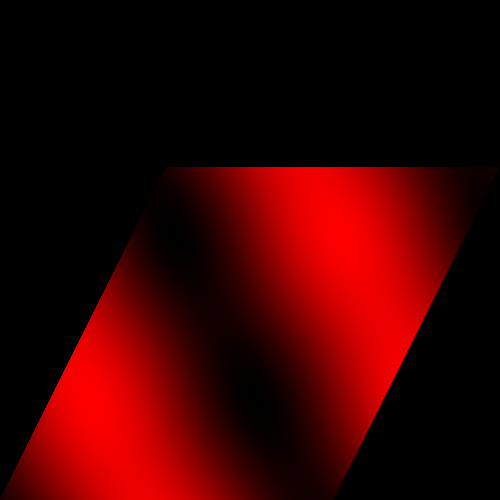

In [11]:
fundamentalRealDict = checkSymmetrySimpleReal(gridApply)
fundamentalCellDisplay(fundamentalRealDict, 500,500)

## Visualize imaginary part of function to detect lack of symmetry and coefficient degeneracies

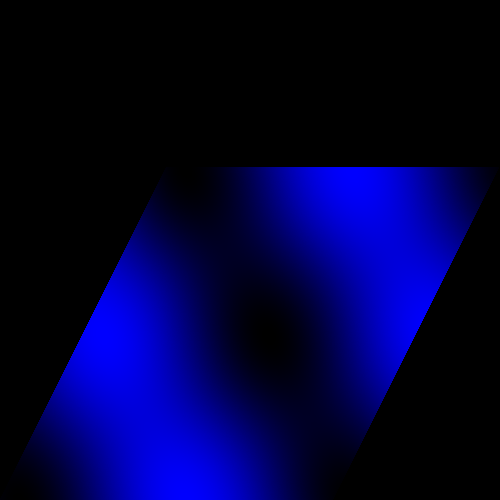

In [12]:
fundamentalImagDict = checkSymmetrySimpleImag(gridApply)
fundamentalCellDisplay(fundamentalImagDict, 500,500)

## Calculate the colors on the fundamental cell grid using the colorwheel

In [13]:
fundamentalColorDict = colorwheelApply(gridApply, colorWheel)

## Here is the fundamental cell using Farris' image colorwheel technique

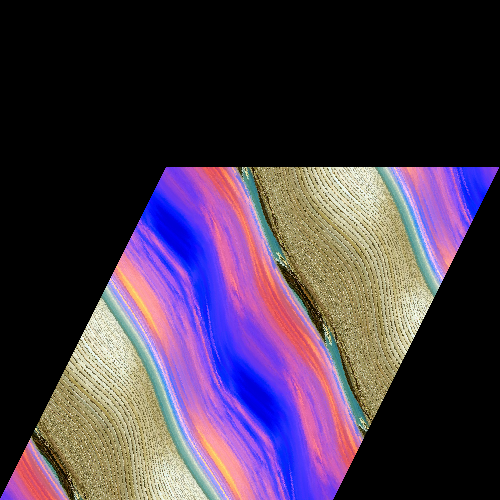

In [14]:
fundamentalCellDisplay(fundamentalColorDict, 500,500)

## Here is a small piece of the wallpaper pattern

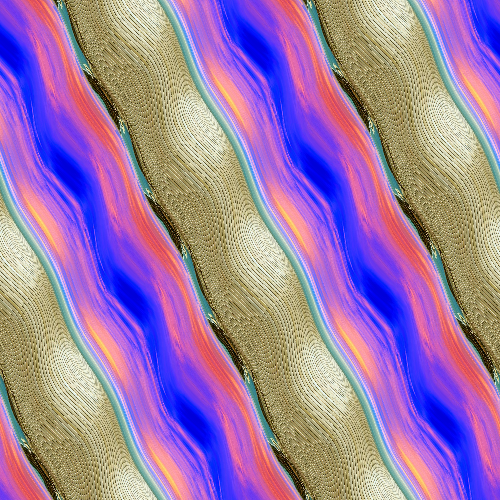

In [ ]:
imOut = tileFundamental(fundamentalColorDict, numStep, xmin=0, xmax=2, ymin=0, ymax=2, resx=500, resy=None)
display(Image.fromarray(imOut))

## Here is the fundamental cell using the alternative visualization technique

In [ ]:
fundamentalSimpleSymDict = checkSymmetrySimple(gridApply)
fundamentalCellDisplay(fundamentalSimpleSymDict, 500,500)

## Here is a small piece of the wallpaper pattern using alternative visualization

In [ ]:
imOut1 = tileFundamental(fundamentalSimpleSymDict, numStep, xmin=-1, xmax=1, ymin=-1, ymax=1, resx=1000, resy=None)
display(Image.fromarray(imOut1))

## Iterate.  Use the new wallpaper pattern as a colorwheel with the same specs!

In [ ]:
imRecursive = imOut

In [ ]:
fundamentalColorDict2 = colorwheelApply(gridApply, imRecursive)
imRecursive = tileFundamental(fundamentalColorDict2, numStep, xmin=0, xmax=2, ymin=0, ymax=2, resx=500, resy=None)
display(Image.fromarray(imRecursive))